# Pensacola Bay FL - Detailed step-by-step

## Standardize, clean and wrangle Water Quality Portal data in Pensacola and Perdido Bays into more analytic-ready formats using the harmonize_wq package


US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:

- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different water quality parameters in Pensacola and Perdido Bays

#### Install and import the required libraries

In [1]:
import sys
#!python -m pip uninstall harmonize-wq --yes
#!python -m pip install harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git@new_release_0-3-8

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize
from harmonize_wq import visualize
from harmonize_wq import clean

#### Download location data using dataretrieval

<Axes: >

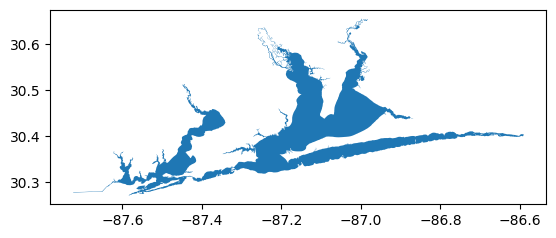

In [3]:
# Read geometry for Area of Interest from geojson file url and plot
aoi_url = r'https://raw.githubusercontent.com/USEPA/harmonize-wq/main/harmonize_wq/tests/data/PPBays_NCCA.geojson'
aoi_gdf = wrangle.as_gdf(aoi_url).to_crs(epsg=4326)  # already standard 4326
aoi_gdf.plot()

In [4]:
# Note there are actually two polygons (one for each Bay)
aoi_gdf
# Spatial query parameters can be updated to run just one
bBox = wrangle.get_bounding_box(aoi_gdf)
# For only one bay, e.g., first is Pensacola Bay:
#bBox = wrangle.get_bounding_box(aoi_gdf, 0)

In [5]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = bBox

In [6]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [7]:
# Rows and columns for results
stations.shape

(2631, 37)

In [8]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-AL,USGS Alabama Water Science Center,USGS-02376115,"ELEVENMILE CREEK NR WEST PENSACOLA, FL",Stream,NaN,3140107.0,27.8,sq mi,27.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-AL,USGS Alabama Water Science Center,USGS-02377570,"STYX RIVER NEAR ELSANOR, AL.",Stream,NaN,3140106.0,192.0,sq mi,192.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-AL,USGS Alabama Water Science Center,USGS-02377920,"BLACKWATER RIVER AT US HWY 90 NR ROBERTSDALE, AL.",Stream,NaN,3140106.0,23.1,sq mi,23.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-AL,USGS Alabama Water Science Center,USGS-02377960,"BLACKWATER RIVER AT CO RD 87 NEAR ELSANOR, AL.",Stream,NaN,3140106.0,56.6,sq mi,56.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-AL,USGS Alabama Water Science Center,USGS-02377975,BLACKWATER RIVER ABOVE SEMINOLE AL,Stream,NaN,3140106.0,40.2,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [9]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 30.498252
LongitudeMeasure                               -87.335809
Name: 0, dtype: object

In [10]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, out_EPSG=4326, intermediate_columns=True)

In [11]:
location.harmonize_locations?

Signature:
location.harmonize_locations(
    df_in,
    out_EPSG=4326,
    intermediate_columns=False,
    **kwargs,
)
Docstring:
Create harmonized geopandas GeoDataframe from pandas DataFrame.

Takes a :class:`~pandas.DataFrame` with lat/lon in multiple Coordinate
Reference Systems (CRS), transforms them to out_EPSG CRS, and converts to
:class:`geopandas.GeoDataFrame`. A 'QA_flag' column is added to the result
and populated for any row that has location based problems like limited
decimal precision or an unknown input CRS.

Parameters
----------
df_in : pandas.DataFrame
    DataFrame with the required columns (see kwargs for expected defaults)
    to be converted to GeoDataFrame.
out_EPSG : int, optional
    EPSG factory code for desired output Coordinate Reference System datum.
    The default is 4326, for the WGS84 Datum used by WQP queries.
intermediate_columns : Boolean, optional
    Return intermediate columns. Default 'False' does not return these.
**kwargs: optional
   Accepts 

In [12]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(2631, 42)

In [13]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-87.3358086, 30.49825159)
EPSG                                  4269.0
QA_flag                                  NaN
geom         POINT (-87.3358086 30.49825159)
geometry     POINT (-87.3358086 30.49825159)
Name: 0, dtype: object

In [14]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [15]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed'}

<Axes: >

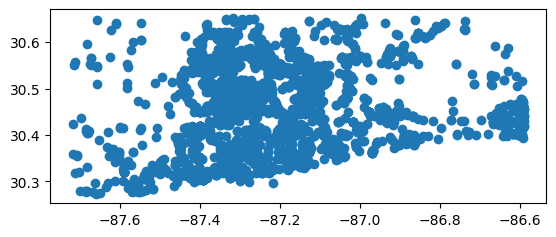

In [16]:
# Map it
stations_gdf.plot()

In [17]:
# Clip to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

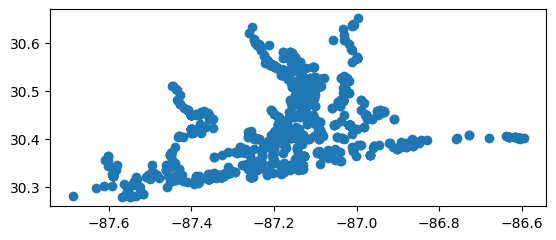

In [18]:
# Map it
stations_clipped.plot()

In [19]:
# How many stations now?
len(stations_clipped)

1261

In [20]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path, 'PPBEP_stations.shp'))

#### Retrieve Characteristic Data

In [21]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\dataretrieval\wqp.py:83: DtypeWarning: Columns (9,10,13,15,17,19,20,21,22,23,28,31,33,34,36,58,60,61,64,65,69,70,71,72,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')


In [22]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1536988F1,2013-09-17,11:01:00,EST,21FLPNS_WQX-33030019,STORET-308146602,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1520810L,2013-07-23,10:01:00,EST,21FLPNS_WQX-33020146,STORET-308157908,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
2,21FLCBA_WQX,CHOCTAWHATCHEE BASIN ALLIANCE,21FLCBA_WQX-BAS219848-162813,2013-09-23,17:15:00,CST,21FLCBA_WQX-BAS02,STORET-760593202,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-028800618132,2013-06-18,11:01:00,EST,21FLSEAS_WQX-02SEAS880,STORET-310466105,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,21FLBFA_WQX,"FL Dept of Environmental Protection , Bream Fi...",21FLBFA_WQX-1558337F1,2013-12-01,13:01:00,EST,21FLBFA_WQX-33020LT2,STORET-291224060,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384415,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-G4NW0509-10/17/23,2023-10-17,11:05:00,EST,21FLPNS_WQX-G4NW0509,STORET-993424039,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NELAC,NaN,NaN,NaN,STORET
384416,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-G4NW0509-10/17/23-FP1,2023-10-17,11:05:00,EST,21FLPNS_WQX-G4NW0509,STORET-993436286,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
384417,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-G5NW0068-10/17/23,2023-10-17,09:10:00,EST,21FLPNS_WQX-G5NW0068,STORET-993415132,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NELAC,NaN,NaN,NaN,STORET
384418,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-G4NW0508-10/17/23-FP2,2023-10-17,11:55:00,EST,21FLPNS_WQX-G4NW0508,STORET-993431681,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET


<Axes: >

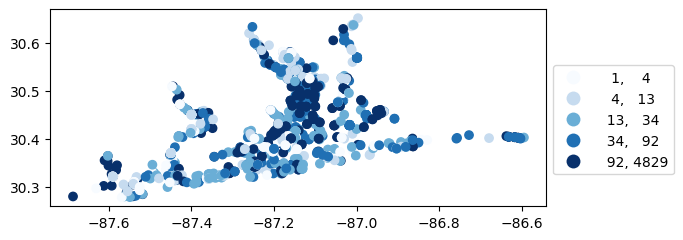

In [23]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic(). harmonize_all runs functions on all characteristics and lets you specify how to handle errors harmonize_generic runs functions only on the characteristic specified with char_val and lets you also choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [24]:
# See Documentation
#harmonize.harmonize_all?
#harmonize.harmonize?

##### secchi disk depth

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    12978.000000
mean         1.186557
std          2.433313
min          0.000000
25%          0.600000
50%          1.000000
75%          1.500000
max        260.000000
dtype: float64
Unusable results: 66
Usable results with inferred units: 0
Results outside threshold (0.0 to 15.78643488828023): 1


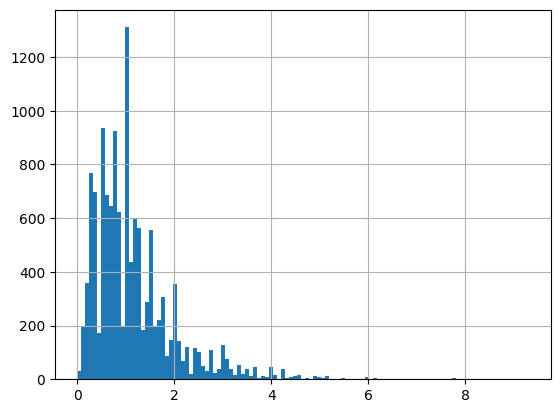

In [25]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [26]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
48,21FLPNS_WQX-33020JF1,0.60,m,NaN,m,0.6 meter
55,21FLGW_WQX-3565,.3,m,NaN,m,0.3 meter
59,21FLBFA_WQX-33010016,1.5,m,NaN,m,1.5 meter
100,21AWIC-7290,.94,m,NaN,m,0.94 meter
119,21AWIC-1208,.49,m,NaN,m,0.49 meter
...,...,...,...,...,...,...
384356,21FLPNS_WQX-G4NW0032,1,m,NaN,m,1.0 meter
384367,21FLPNS_WQX-G5NW0035,0.7,m,NaN,m,0.7 meter
384380,21FLPNS_WQX-G5NW0007,0.9,m,NaN,m,0.9 meter
384381,21FLPNS_WQX-G4NW0035,1.2,m,NaN,m,1.2 meter


In [27]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
156045,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
156091,21FLKWAT_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
156419,21FLCBA_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
156508,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
157476,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
383359,21FLCBA_WQX-OKA-CBA-GAP-1-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
383497,21FLCBA_WQX-OKA-CB-BASS-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
383628,21FLCBA_WQX-OKA-CBA-GAP-1-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
383862,21FLCBA_WQX-OKA-CB-BASS-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


In [28]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used; ResultMeasure/MeasureUnitCode: MISSING UNITS, m assumed'

In [29]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
156045,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
156091,21FLKWAT_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
156419,21FLCBA_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
156508,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
157476,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
383359,21FLCBA_WQX-OKA-CBA-GAP-1-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
383497,21FLCBA_WQX-OKA-CB-BASS-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
383628,21FLCBA_WQX-OKA-CBA-GAP-1-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
383862,21FLCBA_WQX-OKA-CB-BASS-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


If both value and unit are missing nothing can be done, a unitless (NaN) value is assumed as to be in default units but a QA_flag is added

In [30]:
# Aggregate Secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_CMP_PKT01,12,2.333333
1,11NPSWRD_WQX-GUIS_CMP_PKT02,17,2.411765
2,11NPSWRD_WQX-GUIS_CMP_PKT03,3,2.333333
3,21AWIC-1063,116,0.767931
4,21AWIC-1122,56,2.790786
...,...,...,...
903,NARS_WQX-NCCA10-1432,1,1.075000
904,NARS_WQX-NCCA10-1433,1,1.423333
905,NARS_WQX-NCCA10-1434,1,2.400000
906,NARS_WQX-NCCA10-1488,1,0.736667


<Axes: >

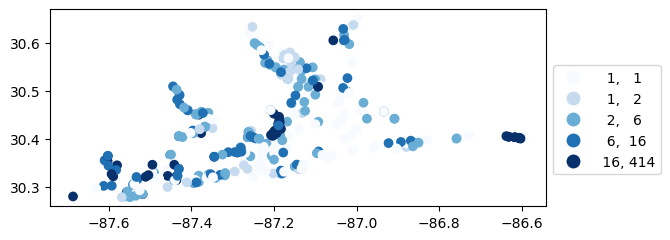

In [31]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

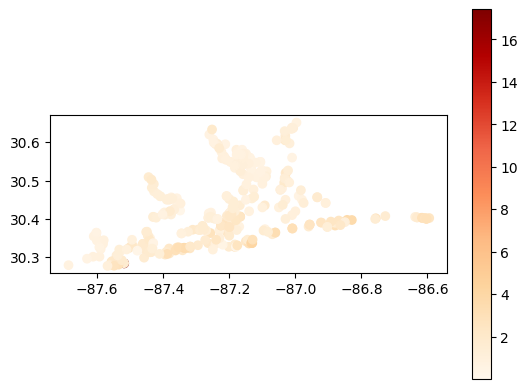

In [32]:
# Map average secchi depth results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    74485.000000
mean        21.884964
std         10.684321
min        -12.944444
25%         16.920000
50%         22.190000
75%         27.100000
max       1876.000000
dtype: float64
Unusable results: 2
Usable results with inferred units: 10
Results outside threshold (0.0 to 85.99088705900843): 6


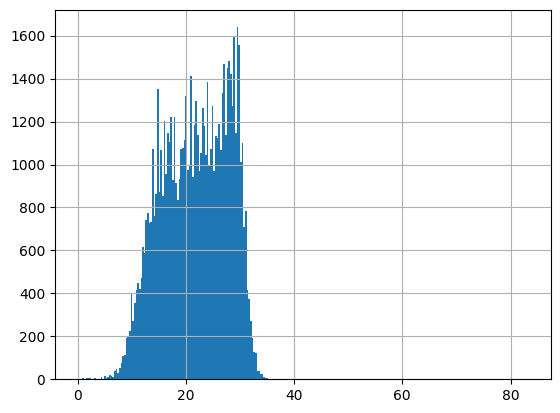

In [33]:
#'Temperature, water'
# errors=‘ignore’, invalid dimension conversions will return the NaN.
df = harmonize.harmonize(df, 'Temperature, water', intermediate_columns=True, report=True, errors='ignore')

In [34]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
2,21FLCBA_WQX-BAS02,78.9,deg F,NaN,26.0555555555556 degree_Celsius,degF
21,21FLPNS_WQX-33030019,23.12,deg C,NaN,23.12 degree_Celsius,degC
33,21FLPNS_WQX-330300G9,16.43,deg C,NaN,16.43 degree_Celsius,degC
34,21FLPNS_WQX-33010H24,29.78,deg C,NaN,29.78 degree_Celsius,degC
36,21FLPNS_WQX-33010G10,26.72,deg C,NaN,26.72 degree_Celsius,degC
...,...,...,...,...,...,...
384395,21FLPNS_WQX-G5NW0007,26.8,deg C,NaN,26.8 degree_Celsius,degC
384408,21FLPNS_WQX-G5NW0007,27.5,deg C,NaN,27.5 degree_Celsius,degC
384409,21FLPNS_WQX-G5NW0035,27.8,deg C,NaN,27.8 degree_Celsius,degC
384418,21FLPNS_WQX-G4NW0508,24.5,deg C,NaN,24.5 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [35]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
141086,NARS_WQX-OWW04440-0401,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
209453,21FLCBA-FWB05,79.8,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",79.8 degree_Celsius,degC
209519,21FLCBA-FWB05,81.7,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",81.7 degree_Celsius,degC
210400,21FLCBA-FWB02,82.1,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",82.1 degree_Celsius,degC
210401,21FLCBA-FWB02,82.6,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",82.6 degree_Celsius,degC
210402,21FLCBA-FWB02,71.8,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",71.8 degree_Celsius,degC
210403,21FLCBA-FWB02,79.4,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",79.4 degree_Celsius,degC
216083,21FLCBA-RIV02,74.2,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",74.2 degree_Celsius,degC
216084,21FLCBA-RIV02,74.2,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",74.2 degree_Celsius,degC
220715,21FLCBA-FWB01,83.3,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",83.3 degree_Celsius,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [36]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasureValue: missing (NaN) result; ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [37]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
49379,11NPSWRD_WQX-GUIS_NALO,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
141086,NARS_WQX-OWW04440-0401,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


In [38]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_ADEM_ALPT,30,24.986667
1,11NPSWRD_WQX-GUIS_BCCA,1,36.800000
2,11NPSWRD_WQX-GUIS_BISA,32,22.696250
3,11NPSWRD_WQX-GUIS_BOPI,1,32.000000
4,11NPSWRD_WQX-GUIS_CMP_PKT01,20,25.125000
...,...,...,...
2232,UWFCEDB_WQX-SRC-AI31-22,10,23.020000
2233,UWFCEDB_WQX-SRC-AI36-22,10,23.230000
2234,UWFCEDB_WQX-SRC-AI42-22,10,22.650000
2235,UWFCEDB_WQX-SRC-AI44-22,10,22.890000


<Axes: >

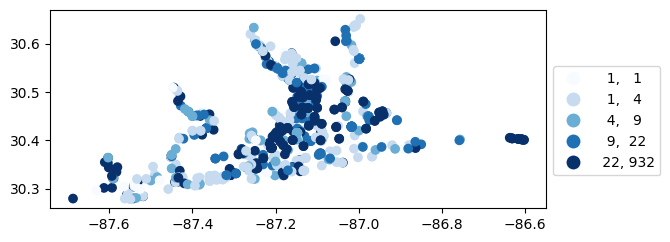

In [39]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

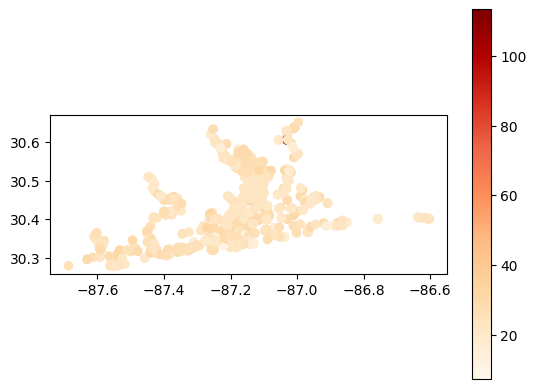

In [40]:
# Map average temperature results at each station
gdf_temperature = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_temperature.plot(column='mean', cmap='OrRd', legend=True)

###### Dissolved oxygen

In [41]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize(df, 'Dissolved oxygen (DO)')

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [42]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
7,21FLPNS_WQX-33030D71,6.64,mg/L,NaN,6.64 milligram / liter
19,21FLCBA_WQX-SRS03,6.28,mg/L,NaN,6.28 milligram / liter
20,21FLPNS_WQX-33020K20,4.53,mg/L,NaN,4.53 milligram / liter
24,21FLPNS_WQX-33030019,9.32,mg/L,NaN,9.32 milligram / liter
27,21FLCMP_WQX-3201BM21,4.5,mg/L,NaN,4.5 milligram / liter
...,...,...,...,...,...
384397,21AWIC-1152,8.89,mg/L,NaN,8.89 milligram / liter
384398,21FLPNS_WQX-G4NW0035,8.64,mg/L,NaN,8.64 milligram / liter
384400,21FLPNS_WQX-G4NW0508,7.97,mg/L,NaN,7.97 milligram / liter
384410,21FLPNS_WQX-G5NW0068,9.13,mg/L,NaN,9.13 milligram / liter


In [43]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
7,21FLPNS_WQX-33030D71,6.64,mg/L,NaN,6.64 milligram / liter
19,21FLCBA_WQX-SRS03,6.28,mg/L,NaN,6.28 milligram / liter
20,21FLPNS_WQX-33020K20,4.53,mg/L,NaN,4.53 milligram / liter
24,21FLPNS_WQX-33030019,9.32,mg/L,NaN,9.32 milligram / liter
27,21FLCMP_WQX-3201BM21,4.5,mg/L,NaN,4.5 milligram / liter
...,...,...,...,...,...
384397,21AWIC-1152,8.89,mg/L,NaN,8.89 milligram / liter
384398,21FLPNS_WQX-G4NW0035,8.64,mg/L,NaN,8.64 milligram / liter
384400,21FLPNS_WQX-G4NW0508,7.97,mg/L,NaN,7.97 milligram / liter
384410,21FLPNS_WQX-G5NW0068,9.13,mg/L,NaN,9.13 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [44]:
# Aggregate DO data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_ADEM_ALPT,30,6.698000
1,11NPSWRD_WQX-GUIS_BCCA,1,0.270000
2,11NPSWRD_WQX-GUIS_BISA,32,7.194375
3,11NPSWRD_WQX-GUIS_BOPI,1,7.540000
4,11NPSWRD_WQX-GUIS_FPPO,1,9.950000
...,...,...,...
1845,UWFCEDB_WQX-SRC-AI31-22,20,3.723390
1846,UWFCEDB_WQX-SRC-AI36-22,20,3.513705
1847,UWFCEDB_WQX-SRC-AI42-22,20,3.677337
1848,UWFCEDB_WQX-SRC-AI44-22,20,3.658370


<Axes: >

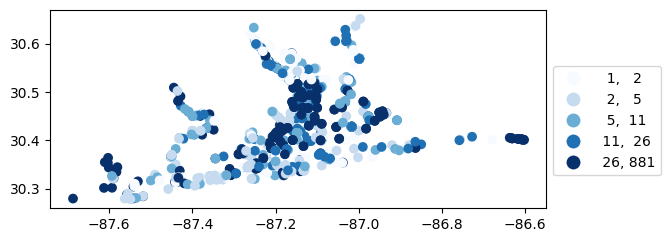

In [45]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

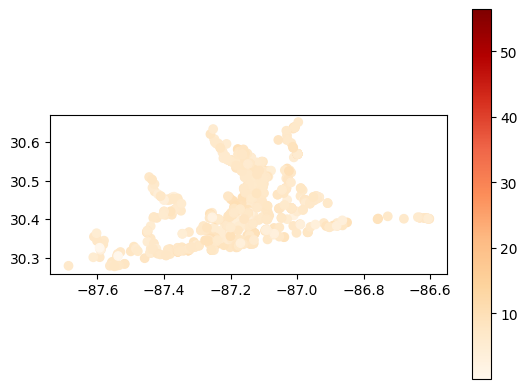

In [46]:
# Map Averages at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

###### pH

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    53275.000000
mean         7.351911
std          0.904735
min          0.500000
25%          6.890000
50%          7.700000
75%          8.000000
max         16.200000
dtype: float64
Unusable results: 51
Usable results with inferred units: 36
Results outside threshold (0.0 to 12.780318316667021): 1


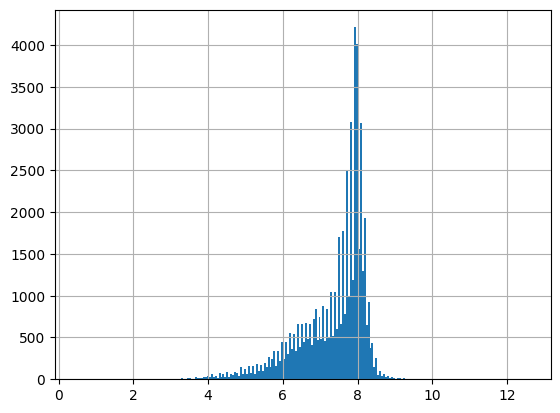

In [47]:
# pH, this time looking at a report
df = harmonize.harmonize(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [48]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
0,7.29,None,NaN,7.29 dimensionless
11,7.45,None,NaN,7.45 dimensionless
13,6.57,None,NaN,6.57 dimensionless
14,6.57,None,NaN,6.57 dimensionless
16,7.72,None,NaN,7.72 dimensionless
...,...,...,...,...
384406,7.2,None,NaN,7.2 dimensionless
384407,7.3,None,NaN,7.3 dimensionless
384411,7.64,None,NaN,7.64 dimensionless
384414,4.98,None,NaN,4.98 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

###### Salinity

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    67623.000000
mean        16.269404
std        157.060309
min          0.000000
25%          6.600000
50%         16.400000
75%         23.580000
max      37782.000000
dtype: float64
Unusable results: 416
Usable results with inferred units: 10
Results outside threshold (0.0 to 958.6312594284706): 4


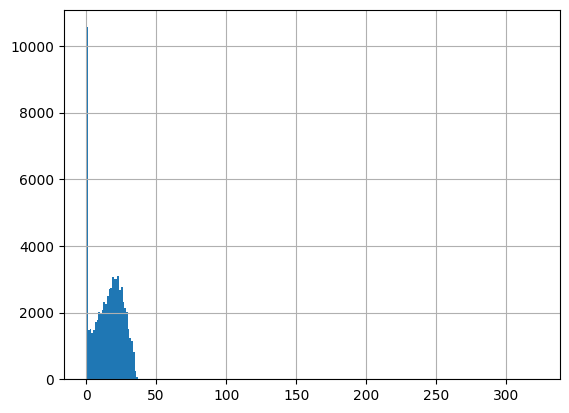

In [49]:
# Salinity
df = harmonize.harmonize(df, 'Salinity', report=True)

In [50]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
4,18.9,ppth,NaN,18.9 Practical_Salinity_Units
6,11.82,ppth,NaN,11.82 Practical_Salinity_Units
10,.03,ppt,NaN,0.03 Practical_Salinity_Units
15,0.50,ppth,NaN,0.5 Practical_Salinity_Units
17,3.3,ppth,NaN,3.3 Practical_Salinity_Units
...,...,...,...,...
384384,26.3,ppth,NaN,26.3 Practical_Salinity_Units
384387,10.06,ppth,NaN,10.06 Practical_Salinity_Units
384393,17.88,ppth,NaN,17.88 Practical_Salinity_Units
384403,21.01,ppth,NaN,21.01 Practical_Salinity_Units


###### Nitrogen

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\wq_data.py:329: UserWarning: WARNING: 'cm3/g' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count     109.000000
mean       26.920174
std       160.257726
min         0.000700
25%         0.410000
50%         0.629000
75%         1.120000
max      1630.000000
dtype: float64
Unusable results: 4
Usable results with inferred units: 0
Results outside threshold (0.0 to 988.466532186079): 1


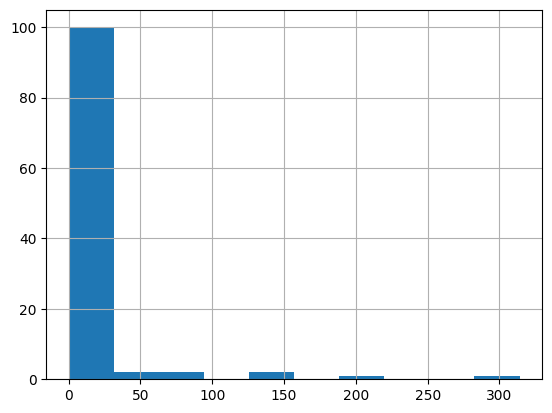

In [51]:
# Nitrogen
df = harmonize.harmonize(df, 'Nitrogen', report=True)

In [52]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
40875,0.3,mg/L,NaN,0.3 milligram / liter
41075,0.36,mg/L,NaN,0.36 milligram / liter
41210,0.33875,mg/L,NaN,0.33875 milligram / liter
41327,0.53125,mg/L,NaN,0.53125 milligram / liter
41836,135,mg/kg,NaN,135.00000000000003 milligram / liter
...,...,...,...,...
382877,18.69,mg/l,NaN,18.69 milligram / liter
382884,16.18,mg/l,NaN,16.18 milligram / liter
382885,18.99,mg/l,NaN,18.99 milligram / liter
382888,18.72,mg/l,NaN,18.72 milligram / liter


###### Conductivity

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count     1818.000000
mean     17085.221414
std      16116.889030
min          0.040000
25%        130.000000
50%      16994.750000
75%      30306.650000
max      54886.200000
dtype: float64
Unusable results: 8
Usable results with inferred units: 0
Results outside threshold (0.0 to 113786.55559242623): 0


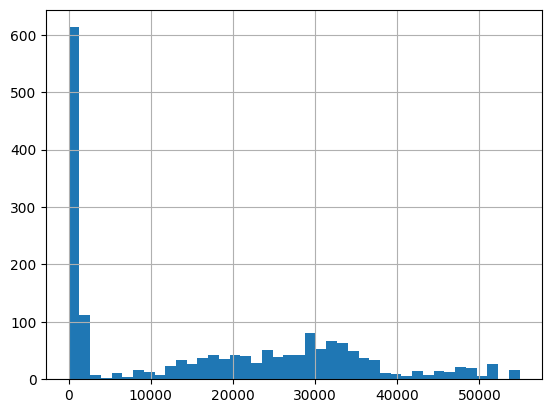

In [53]:
# Conductivity
df = harmonize.harmonize(df, 'Conductivity', report=True)

In [54]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
8,19204.2,umho/cm,NaN,19204.2 microsiemens / centimeter
45,222.3,umho/cm,NaN,222.3 microsiemens / centimeter
221,102.8,umho/cm,NaN,102.8 microsiemens / centimeter
374,11017.5,umho/cm,NaN,11017.5 microsiemens / centimeter
691,32,umho/cm,NaN,32.0 microsiemens / centimeter
...,...,...,...,...
384180,110,umho/cm,NaN,110.0 microsiemens / centimeter
384187,65,umho/cm,NaN,65.0 microsiemens / centimeter
384188,110,umho/cm,NaN,110.0 microsiemens / centimeter
384191,390,umho/cm,NaN,390.0 microsiemens / centimeter


###### Chlorophyll a

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\wq_data.py:329: UserWarning: WARNING: 'None' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\wq_data.py:329: UserWarning: WARNING: 'ug/cm2' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    9235.000000
mean        1.173530
std         1.200244
min        -0.840000
25%         0.008460
50%         0.970000
75%         1.850000
max         9.990000
dtype: float64
Unusable results: 551
Usable results with inferred units: 0
Results outside threshold (0.0 to 8.374993385424874): 8


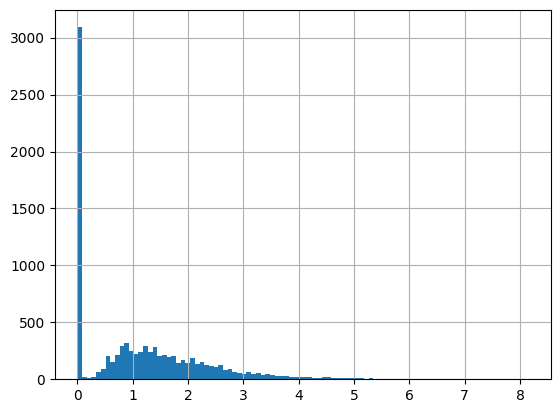

In [55]:
# Chlorophyll a
df = harmonize.harmonize(df, 'Chlorophyll a', report=True)

In [56]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
251,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
525,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
621,2.3,mg/m3,NaN,0.0023000000000000004 milligram / liter
1135,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
1270,2.9,mg/m3,NaN,0.0029000000000000007 milligram / liter
...,...,...,...,...
384006,6.73,ug/L,NaN,0.006730000000000001 milligram / liter
384013,1.89,ug/L,NaN,0.00189 milligram / liter
384050,4.08,ug/L,NaN,0.00408 milligram / liter
384121,1.62,ug/L,NaN,0.0016200000000000001 milligram / liter


###### Organic Carbon

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count      4428.000000
mean       1240.193144
std       12094.529994
min           0.000000
25%           2.600000
50%           4.300000
75%           8.600000
max      410000.000000
dtype: float64
Unusable results: 161
Usable results with inferred units: 0
Results outside threshold (0.0 to 73807.37310572137): 22


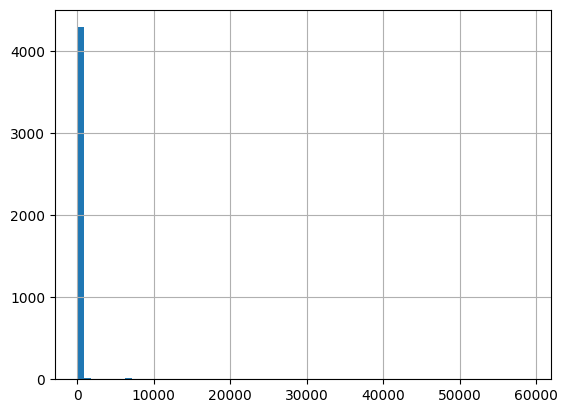

In [57]:
# Organic carbon (%)
df = harmonize.harmonize(df, 'Organic carbon', report=True)

In [58]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
121,2.6,mg/L,NaN,2.6 milligram / liter
170,5.2,mg/L,NaN,5.2 milligram / liter
176,NaN,mg/L,ResultMeasureValue: missing (NaN) result,NaN
208,3.9,mg/L,NaN,3.9 milligram / liter
240,2.5,mg/L,NaN,2.5 milligram / liter
...,...,...,...,...
384339,5.9,mg/L,NaN,5.9 milligram / liter
384358,1.353,mg/L,NaN,1.353 milligram / liter
384360,6.7,mg/L,NaN,6.7 milligram / liter
384371,2.7,mg/L,NaN,2.7 milligram / liter


###### Turbidity

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    37839.000000
mean         9.069313
std        211.094933
min         -0.840000
25%          1.400000
50%          2.500000
75%          4.810000
max      32342.452300
dtype: float64
Unusable results: 167
Usable results with inferred units: 10
Results outside threshold (0.0 to 1275.6389091265294): 45


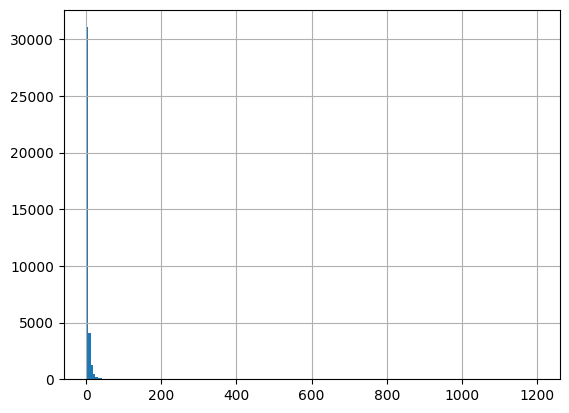

In [59]:
# Turbidity (NTU)
df = harmonize.harmonize(df, 'Turbidity', report=True)

In [60]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
12,0,NTU,NaN,0.0 Nephelometric_Turbidity_Units
49,5.6,NTU,NaN,5.6 Nephelometric_Turbidity_Units
51,28,NTU,NaN,28.0 Nephelometric_Turbidity_Units
70,2,NTU,NaN,2.0 Nephelometric_Turbidity_Units
85,1.4,NTU,NaN,1.4 Nephelometric_Turbidity_Units
...,...,...,...,...
384355,2.2,NTU,NaN,2.2 Nephelometric_Turbidity_Units
384359,3.3,NTU,NaN,3.3 Nephelometric_Turbidity_Units
384391,6.2,NTU,NaN,6.2 Nephelometric_Turbidity_Units
384402,2.7,NTU,NaN,2.7 Nephelometric_Turbidity_Units


###### Sediment

In [61]:
# Sediment
df = harmonize.harmonize(df, 'Sediment', report=False)

In [62]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment


###### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [63]:
# Phosphorus
df = harmonize.harmonize(df, 'Phosphorus')

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


2 Phosphorus sample fractions not in frac_dict
2 Phosphorus sample fractions not in frac_dict found in expected domains, mapped to "Other_Phosphorus"


Note: warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [64]:
# All Phosphorus
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']
df.loc[df['Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
18,.061,mg/L,NaN,NaN
140,.13,mg/L,NaN,NaN
154,0.003,mg/L,NaN,NaN
340,0.002,mg/L,NaN,NaN
389,0.020,mg/L,NaN,NaN
...,...,...,...,...
384353,0.03,mg/L,NaN,NaN
384366,0.003,mg/L,NaN,NaN
384379,.038,mg/L,NaN,NaN
384396,0.012,mg/L,NaN,NaN


In [65]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
18,.061,mg/L,NaN,NaN
140,.13,mg/L,NaN,NaN
154,0.003,mg/L,NaN,NaN
340,0.002,mg/L,NaN,NaN
389,0.020,mg/L,NaN,NaN
...,...,...,...,...
384353,0.03,mg/L,NaN,NaN
384366,0.003,mg/L,NaN,NaN
384379,.038,mg/L,NaN,NaN
384396,0.012,mg/L,NaN,NaN


In [66]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
3412,0.019,mg/L,NaN,0.019 milligram / liter
7602,0.002,mg/L,NaN,0.002 milligram / liter
21804,0.003,mg/L,NaN,0.003 milligram / liter
24836,0.019,mg/L,NaN,0.019 milligram / liter
53271,0.002,mg/L,NaN,0.002 milligram / liter
54958,0.017,mg/L,NaN,0.017 milligram / liter
69627,0.021,mg/L,NaN,0.021 milligram / liter
72233,0.003,mg/L,NaN,0.003 milligram / liter
96204,0.020,mg/L,NaN,0.02 milligram / liter
101292,0.002,mg/L,NaN,0.002 milligram / liter


In [67]:
# All other phosphorus sample fractions
df.loc[df['Other_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
9580,.5,mg/L,NaN,NaN
9684,.036,mg/L,NaN,NaN
10920,.089,mg/L,NaN,NaN
11887,.017,mg/L,NaN,NaN
12938,.067,mg/L,NaN,NaN
...,...,...,...,...
384150,.18,mg/L,NaN,NaN
384161,.25,mg/L,NaN,NaN
384173,.16,mg/L,NaN,NaN
384176,.18,mg/L,NaN,NaN


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:142: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:142: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:142: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    10035.000000
mean        45.537618
std        448.839329
min          0.000000
25%          4.000000
50%          8.000000
75%         33.000000
max      33000.000000
dtype: float64
Unusable results: 40551
Usable results with inferred units: 0
Results outside threshold (0.0 to 2738.5735941387825): 6


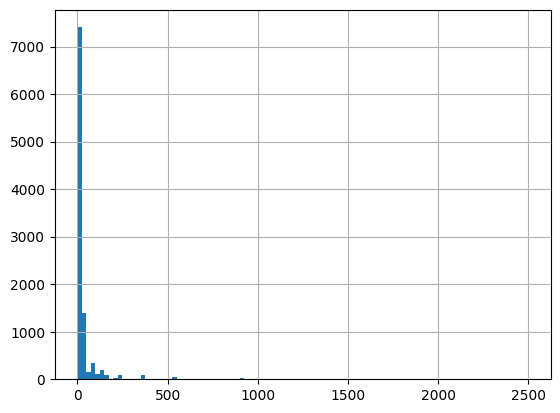

In [68]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Fecal Coliform', report=True, errors='ignore')

In [69]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
1,80,cfu/100mL,NaN,NaN
3,2,MPN/100mL,NaN,NaN
5,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
9,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
26,40,cfu/100mL,NaN,NaN
...,...,...,...,...
383681,120,cfu/100mL,NaN,NaN
383809,52,cfu/100mL,NaN,NaN
384095,54,cfu/100mL,NaN,NaN
384362,61,cfu/100mL,NaN,NaN


###### Escherichia coli

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:142: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\harmonize_wq\harmonize.py:142: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count      22.000000
mean      501.863636
std       610.053260
min         4.000000
25%         9.500000
50%        77.500000
75%      1000.000000
max      1700.000000
dtype: float64
Unusable results: 2863
Usable results with inferred units: 0
Results outside threshold (0.0 to 4162.183198738116): 0


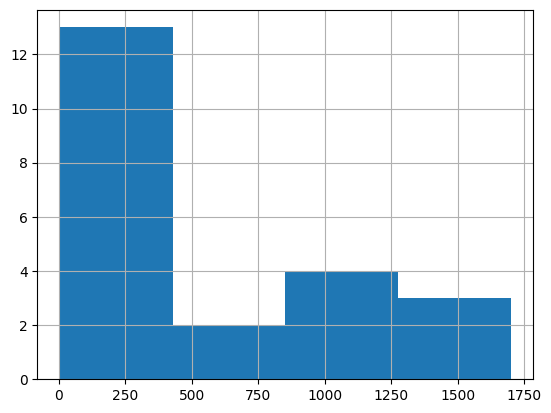

In [70]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Escherichia coli', report=True, errors='ignore')

In [71]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
278,190,MPN/100mL,NaN,NaN
1079,36,MPN/100mL,NaN,NaN
1848,63,MPN/100mL,NaN,NaN
2032,44,#/100mL,NaN,NaN
2458,270,#/100mL,NaN,NaN
...,...,...,...,...
384045,74.0,MPN/100mL,NaN,NaN
384091,4611,MPN/100mL,NaN,NaN
384340,75,MPN/100mL,NaN,NaN
384351,130,MPN/100mL,NaN,NaN


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Explore Salinity results:

In [72]:
from harmonize_wq import convert

In [73]:
# Salinity summary statistics
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: 0.0 to 37782.0
Results: 67623 
Mean: 16.269403694009615 PSU


In [74]:
# Identify extreme outliers
[x for x in lst if x >3200]

[15030.0, 37782.0]

Other fields like units and QA_flag may help understand what caused high values and what results might need to be dropped from consideration

In [75]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [76]:
# Look at important fields for max 5 values
salinity_series = df['Salinity'][df['Salinity'].notna()]
salinity_series.sort_values(ascending=False, inplace=True)
df[cols][df['Salinity'].isin(salinity_series[0:5])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
20414,15030,ppt,NaN,15030.0 Practical_Salinity_Units
29522,322,ppth,NaN,322.0 Practical_Salinity_Units
40404,2150,ppth,NaN,2150.0 Practical_Salinity_Units
65806,37782,ppth,NaN,37782.0 Practical_Salinity_Units
136216,2190,ppt,NaN,2190.0 Practical_Salinity_Units


Detection limits may help understand what caused low values and what results might need to be dropped or updated

In [77]:
from harmonize_wq import wrangle

In [78]:
df = wrangle.add_detection(df, 'Salinity')
cols+=['ResultDetectionConditionText',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode']

In [79]:
# Look at important fields for min 5 values (often multiple 0.0)
df[cols][df['Salinity'].isin(salinity_series[-5:])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,ResultDetectionConditionText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode
2068,0.00,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
3526,0.00,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
17708,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
25649,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
30850,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
299749,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
299788,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
332789,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
332993,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN


Explore Conductivity results:

In [80]:
# Create series and inspect Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

8         19204.2 microsiemens / centimeter
45          222.3 microsiemens / centimeter
221         102.8 microsiemens / centimeter
374       11017.5 microsiemens / centimeter
691          32.0 microsiemens / centimeter
                        ...                
384180      110.0 microsiemens / centimeter
384187       65.0 microsiemens / centimeter
384188      110.0 microsiemens / centimeter
384191      390.0 microsiemens / centimeter
384193       65.0 microsiemens / centimeter
Name: Conductivity, Length: 1818, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm, use a higher threshold for coastal waters

In [81]:
# Sort and check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.sort_values(by=['Conductivity'], ascending=False, inplace=True)
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
123204,54886.2,umho/cm,NaN,NaN,54886.2 microsiemens / centimeter
126411,54871.3,umho/cm,NaN,NaN,54871.3 microsiemens / centimeter
119986,54860.6,umho/cm,NaN,NaN,54860.6 microsiemens / centimeter
125189,54859.3,umho/cm,NaN,NaN,54859.3 microsiemens / centimeter
119414,54850.8,umho/cm,NaN,NaN,54850.8 microsiemens / centimeter
...,...,...,...,...,...
81788,6.8,umho/cm,NaN,NaN,6.8 microsiemens / centimeter
48865,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
136344,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
34887,1,umho/cm,NaN,NaN,1.0 microsiemens / centimeter


In [82]:
# Check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
123204,54886.2,umho/cm,NaN,NaN,54886.2 microsiemens / centimeter
126411,54871.3,umho/cm,NaN,NaN,54871.3 microsiemens / centimeter
119986,54860.6,umho/cm,NaN,NaN,54860.6 microsiemens / centimeter
125189,54859.3,umho/cm,NaN,NaN,54859.3 microsiemens / centimeter
119414,54850.8,umho/cm,NaN,NaN,54850.8 microsiemens / centimeter
...,...,...,...,...,...
81788,6.8,umho/cm,NaN,NaN,6.8 microsiemens / centimeter
48865,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
136344,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
34887,1,umho/cm,NaN,NaN,1.0 microsiemens / centimeter


In [83]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

123204    36.356 dimensionless
126411    36.345 dimensionless
119986    36.338 dimensionless
125189    36.336 dimensionless
119414     36.33 dimensionless
                  ...         
81788      0.013 dimensionless
48865      0.012 dimensionless
136344     0.012 dimensionless
34887      0.012 dimensionless
137479     0.012 dimensionless
Name: Salinity, Length: 1818, dtype: object

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [84]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
123204,2007-08-09,12:15:00,CST
126411,2007-08-09,12:15:00,CST
119986,2007-08-09,12:15:00,CST
125189,2007-08-09,12:15:00,CST
119414,2007-08-09,12:15:00,CST
...,...,...,...
384415,2023-10-17,11:05:00,EST
384416,2023-10-17,11:05:00,EST
384417,2023-10-17,09:10:00,EST
384418,2023-10-17,11:55:00,EST


In [85]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\dataretrieval\utils.py:87: UserWarning: Warning: 35994 incomplete dates found, consider setting datetime_index to False.
  warnings.warn(


,ActivityStartDate,Activity_datetime
123204,2007-08-09,2007-08-09 18:15:00+00:00
126411,2007-08-09,2007-08-09 18:15:00+00:00
119986,2007-08-09,2007-08-09 18:15:00+00:00
125189,2007-08-09,2007-08-09 18:15:00+00:00
119414,2007-08-09,2007-08-09 18:15:00+00:00
...,...,...
384415,2023-10-17,2023-10-17 16:05:00+00:00
384416,2023-10-17,2023-10-17 16:05:00+00:00
384417,2023-10-17,2023-10-17 14:10:00+00:00
384418,2023-10-17,2023-10-17 16:55:00+00:00


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a ActivityStartDate column is used to preserve date only.

#### Depth

Note: Data are often lacking sample depth metadata

In [86]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

C:\Users\jbousqui\Local_GIS\Python\v_envs\jupyter-harmonize-39\lib\site-packages\pandas\core\dtypes\cast.py:1784: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


2975       7.0
5566       7.0
69583      0.1
69623      2.2
69689      2.0
          ... 
78338      2.2
80018     16.0
81262     16.0
82395      1.0
131202    35.0
Name: ResultDepthHeightMeasure/MeasureValue, Length: 179, dtype: float64

#### Characteristic to Column (long to wide format)

In [87]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_Carbon,QA_Conductivity,QA_Secchi,QA_Salinity,QA_Chlorophyll,QA_E_coli,QA_Nitrogen,QA_Fecal_Coliform,QA_pH,QA_Temperature
123204,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230231_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383613,230231.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126411,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230230_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383607,230230.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119986,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230228_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383595,230228.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125189,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230229_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383601,230229.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119414,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230227_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383589,230227.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384414,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-G5NW0068-10/17/23-FP1,2023-10-17,09:10:00,-0500,21FLPNS_WQX-G5NW0068,STORET-993431688,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
384416,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-G4NW0509-10/17/23-FP1,2023-10-17,11:05:00,-0500,21FLPNS_WQX-G4NW0509,STORET-993436286,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
384417,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-G5NW0068-10/17/23,2023-10-17,09:10:00,-0500,21FLPNS_WQX-G5NW0068,STORET-993415132,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
384418,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-G4NW0508-10/17/23-FP2,2023-10-17,11:55:00,-0500,21FLPNS_WQX-G4NW0508,STORET-993431681,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

14 new columns


In [89]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

45097 fewer rows


In [90]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [91]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [92]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'TOTAL NITROGEN_ MIXED FORMS', 'Conductivity',
       'Chlorophyll', 'Carbon', 'Turbidity', 'Sediment', 'Phosphorus',
       'TP_Phosphorus', 'TDP_Phosphorus', 'Other_Phosphorus', 'Fecal_Coliform',
       'E_coli', 'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode',
       'Activity_datetime', 'Depth', 'QA_Turbidity', 'QA_DO',
       'QA_TP_Phosphorus', 'QA_TDP_Phosphorus', 'QA_Other_Phosphorus',
       'QA_Carbon', 'QA_Conductivity', 'QA_Secchi', 'QA_Salinity',
       'QA_Chlorophyll', 'QA_E_coli', 'QA_Nitrogen', 'QA_Fecal_Coliform',
       'QA_pH', 'QA_Temperature'],
      dtype='object')

In [93]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_Carbon,QA_Conductivity,QA_Secchi,QA_Salinity,QA_Chlorophyll,QA_E_coli,QA_Nitrogen,QA_Fecal_Coliform,QA_pH,QA_Temperature
123204,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230231_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.356 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126411,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230230_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.345 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119986,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230228_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.338 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125189,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230229_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.336 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119414,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230227_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.33 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'QA_TP_Phosphorus',
 'QA_TDP_Phosphorus',
 'QA_Other_Phosphorus',
 'QA_Carbon',
 'QA_Conductivity',
 'QA_Secchi',
 'QA_E_coli',
 'QA_Fecal_Coliform']

<Axes: >

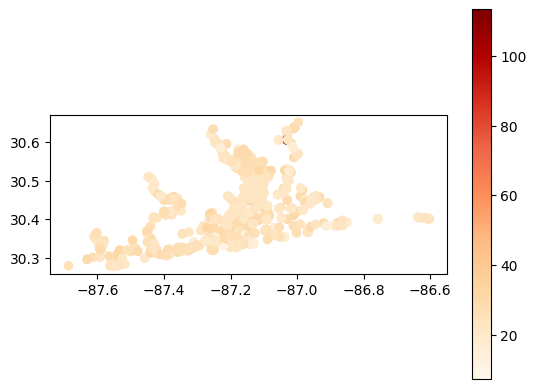

In [95]:
# Map average results at each station
gdf_avg = visualize.map_measure(main_df, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)